In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import k3d
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sys
import tqdm
from functools import partial

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4sbi4nyi because the default path (/home/user/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
import torch
from torch.utils.data import DataLoader

In [15]:
from sharpf.data.datasets.sharpf_io import PointCloudIO, DepthMapIO
from sharpf.utils.abc_utils.hdf5.io_struct import collate_mapping_with_io
from sharpf.utils.abc_utils.hdf5.dataset import LotsOfHdf5Files, Hdf5File, PreloadTypes
from sharpf.utils.abc_utils.torch import *
from sharpf.utils.plotting import display_depth_sharpness

from sharpf.utils.camera_utils.camera_pose import camera_to_display, CameraPose
from sharpf.data.imaging import IMAGING_BY_TYPE
from sharpf.utils.py_utils.config import load_func_from_config

In [5]:
def display_sharpness(mesh=None, plot_meshvert=True,
                      samples=None, samples_distances=None,
                      sharp_vert=None, sharp_curves=None,
                      directions=None, directions_width=0.0025,
                      samples_color=0x0000ff, samples_psize=0.002, 
                      mesh_color=0xbbbbbb, meshvert_color=0x666666, meshvert_psize=0.0025,
                      sharpvert_color=0xff0000, sharpvert_psize=0.0025,
                      sharpcurve_color=None, sharpcurve_width=0.0025,
                      as_image=False, plot_height=768, 
                      cmap_distances=k3d.colormaps.basic_color_maps.WarmCool,
                      distance_range=None):
    
    plot = k3d.plot(height=plot_height, camera_fov=30.0)
    
    if None is not mesh:
        k3d_mesh = k3d.mesh(mesh.vertices, mesh.faces, color=mesh_color)
        plot += k3d_mesh

        if plot_meshvert:
            k3d_points = k3d.points(mesh.vertices, 
                                    point_size=meshvert_psize, color=meshvert_color)
            plot += k3d_points
            k3d_points.shader='flat'

    if None is not samples:
        colors = None
        if None is not samples_distances:
            if None is distance_range:
                distance_range = [0, np.max(samples_distances)]

            colors = k3d.helpers.map_colors(
                samples_distances, cmap_distances, distance_range
            ).astype(np.uint32)
            k3d_points = k3d.points(samples, point_size=samples_psize, colors=colors)
        else:
            k3d_points = k3d.points(samples, point_size=samples_psize, color=samples_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not directions:
            directions_to_plot = np.hstack((samples, samples + directions))
            
            for i, dir_to_plot in enumerate(directions_to_plot):
                dir_to_plot = dir_to_plot.reshape((2, 3))
                if np.all(dir_to_plot[0] == dir_to_plot[1]):
                    continue
                color = int(colors[i]) if None is not colors else samples_color
                plt_line = k3d.line(dir_to_plot, 
                                    shader='mesh', width=directions_width, color=color)
                plot += plt_line

    if None is not sharp_vert:
        k3d_points = k3d.points(sharp_vert,
                                point_size=sharpvert_psize, color=sharpvert_color)
        plot += k3d_points
        k3d_points.shader='flat'
        
        if None is not sharp_curves:            
            if None is not sharpcurve_color:
                color = sharpcurve_color
            else:
                import randomcolor
                rand_color = randomcolor.RandomColor()
            for i, vert_ind in enumerate(sharp_curves):
                sharp_points_curve = mesh.vertices[vert_ind]
                
                if None is sharpcurve_color:
                    color = rand_color.generate(hue='red')[0]
                    color = int('0x' + color[1:], 16)
                plt_line = k3d.line(sharp_points_curve, 
                                    shader='mesh', width=sharpcurve_width, color=color)
                plot += plt_line
        
    plot.grid_visible = False
    plot.camera_auto_fit = True
    plot.display()
    
    return plot

In [6]:
!ls /logs/sharp_features_data_v2/images/

abc_0000_0_1.hdf5    abc_0000_41_42.hdf5  abc_0000_72_73.hdf5
abc_0000_12_13.hdf5  abc_0000_42_43.hdf5  abc_0000_75_76.hdf5
abc_0000_13_14.hdf5  abc_0000_43_44.hdf5  abc_0000_76_77.hdf5
abc_0000_14_15.hdf5  abc_0000_45_46.hdf5  abc_0000_77_78.hdf5
abc_0000_15_16.hdf5  abc_0000_46_47.hdf5  abc_0000_78_79.hdf5
abc_0000_16_17.hdf5  abc_0000_47_48.hdf5  abc_0000_79_80.hdf5
abc_0000_17_18.hdf5  abc_0000_4_5.hdf5	  abc_0000_7_8.hdf5
abc_0000_1_2.hdf5    abc_0000_51_52.hdf5  abc_0000_80_81.hdf5
abc_0000_20_21.hdf5  abc_0000_52_53.hdf5  abc_0000_82_83.hdf5
abc_0000_21_22.hdf5  abc_0000_53_54.hdf5  abc_0000_83_84.hdf5
abc_0000_22_23.hdf5  abc_0000_54_55.hdf5  abc_0000_84_85.hdf5
abc_0000_23_24.hdf5  abc_0000_57_58.hdf5  abc_0000_87_88.hdf5
abc_0000_25_26.hdf5  abc_0000_59_60.hdf5  abc_0000_88_89.hdf5
abc_0000_26_27.hdf5  abc_0000_5_6.hdf5	  abc_0000_89_90.hdf5
abc_0000_28_29.hdf5  abc_0000_60_61.hdf5  abc_0000_90_91.hdf5
abc_0000_29_30.hdf5  abc_0000_61_62.hdf5  abc_0000_91_92.hdf5
abc_0000_2_3

In [16]:
hdf5_input_dir = '/logs/sharp_features_data_v2/images/'
data_label = 'image'
target_label = 'distances'
# labels = ['directions', 'distances', 'has_sharp', 
#           'item_id', 'normals', 'num_sharp_curves', 
#           'num_surfaces', 'orig_face_indexes', 'orig_vert_indices', 'points']
labels = '*'
# labels = ['points',
#           'num_sharp_curves', 
#           'num_surfaces',
#           'camera_pose']

dataset = LotsOfHdf5Files(
        data_dir=hdf5_input_dir,
        io=DepthMapIO,
        data_label=data_label,
        target_label=target_label,
        labels=labels,
        max_loaded_files=10,
    preload=PreloadTypes.LAZY)

# dataset = Hdf5File(
#     '/logs/sharp_features_data_v2/images/test_clean_100_0.hdf5',
#     io=PointCloudIO,
#     data_label=data_label,
#     target_label=target_label,
#     labels='*',
#     transform=None)
len(dataset)

63169

In [27]:
dataset.files[0].labels

['directions',
 'has_smell_deviating_resolution',
 'num_surfaces',
 'mesh_scale',
 'has_smell_coarse_surfaces_by_num_faces',
 'has_smell_depth_discontinuity',
 'orig_face_indexes',
 'num_sharp_curves',
 'normals',
 'has_smell_mismatching_surface_annotation',
 'has_smell_bad_face_sampling',
 'has_smell_coarse_surfaces_by_angles',
 'has_smell_mesh_self_intersections',
 'has_sharp',
 'distances',
 'has_smell_raycasting_background',
 'has_smell_sharpness_discontinuities',
 'image',
 'item_id',
 'orig_vert_indices',
 'camera_pose']

In [9]:
[label for label in dataset.files[0].labels if label.startswith('has_smell')]

['has_smell_deviating_resolution',
 'has_smell_coarse_surfaces_by_num_faces',
 'has_smell_depth_discontinuity',
 'has_smell_mismatching_surface_annotation',
 'has_smell_bad_face_sampling',
 'has_smell_coarse_surfaces_by_angles',
 'has_smell_mesh_self_intersections',
 'has_smell_raycasting_background',
 'has_smell_sharpness_discontinuities']

In [28]:
batch_size = 128
train_loader = DataLoader(
    dataset,
    num_workers=24,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=partial(collate_mapping_with_io, io=DepthMapIO),
)

In [49]:
true_keys = ['has_smell_coarse_surfaces_by_angles', 'has_smell_coarse_surfaces_by_num_faces']
false_keys = ['has_smell_mismatching_surface_annotation', 'has_smell_sharpness_discontinuities']

In [12]:
def select_items_by_predicates(batch, true_keys=None, false_keys=None):
    """Selects sub-batch where item[key] == True for each key in true_keys
    and item[key] == False for each key in false_keys"""
    any_key = next(iter(batch.keys()))
    batch_size = len(batch[any_key])

    if None is not true_keys:
        true_mask = torch.stack([batch[key] for key in true_keys]).all(axis=0)
    else:
        true_mask = torch.ones(batch_size).bool()

    if None is not false_keys:
        false_mask = torch.stack([~batch[key] for key in false_keys]).all(axis=0)
    else:
        false_mask = torch.ones(batch_size).bool()

    selected_idx = torch.where(true_mask * false_mask)[0]
    filtered_batch = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            filtered_batch[key] = value[selected_idx]
        elif isinstance(value, list):
            filtered_batch[key] = [value[i] for i in selected_idx]

    return filtered_batch


In [18]:
has_smell_coarse_surfaces_by_angles = 0
for batch in tqdm.tqdm(train_loader):
    filtered_batch = select_items_by_predicates(batch, false_keys=['has_smell_coarse_surfaces_by_angles'])
    has_smell_coarse_surfaces_by_angles += len(filtered_batch['has_sharp'])

100%|██████████| 494/494 [01:13<00:00,  6.75it/s]


In [19]:
has_smell_coarse_surfaces_by_angles / len(dataset)

0.9852459275910652

In [107]:
has_smell_coarse_surfaces_by_num_faces = 0
for batch in tqdm.tqdm(train_loader):
    filtered_batch = select_items_by_predicates(batch, false_keys=['has_smell_coarse_surfaces_by_num_faces'])
    has_smell_coarse_surfaces_by_num_faces += len(filtered_batch['has_sharp'])

100%|██████████| 7610/7610 [03:38<00:00, 34.83it/s]


In [108]:
has_smell_coarse_surfaces_by_num_faces / len(dataset)

0.8266090613398167

In [23]:
has_smell_sharpness_discontinuities = 0
for batch in tqdm.tqdm(train_loader):
    filtered_batch = select_items_by_predicates(batch, false_keys=['has_smell_sharpness_discontinuities'])
    has_smell_sharpness_discontinuities += len(filtered_batch['has_sharp'])

100%|██████████| 494/494 [01:14<00:00,  6.64it/s]


In [110]:
has_smell_sharpness_discontinuities / len(dataset)

0.9959013700430397

In [29]:
has_smells = 0
for batch in tqdm.tqdm(train_loader):
    filtered_batch = select_items_by_predicates(
        batch, 
        false_keys=[
            'has_smell_deviating_resolution',
            'has_smell_coarse_surfaces_by_num_faces',
            'has_smell_depth_discontinuity',
            'has_smell_mismatching_surface_annotation',
            'has_smell_bad_face_sampling',
            'has_smell_coarse_surfaces_by_angles',
            'has_smell_mesh_self_intersections',
            'has_smell_raycasting_background',
            'has_smell_sharpness_discontinuities'
        ])
    has_smells += len(filtered_batch['has_sharp'])

100%|██████████| 494/494 [01:13<00:00,  6.72it/s]


In [30]:
has_smells / len(dataset)

0.11139957890737545

In [122]:
has_smell_coarse_surfaces_by_angles = 0
for batch in tqdm.tqdm(train_loader):
    filtered_batch = select_items_by_predicates(batch)
    has_smell_coarse_surfaces_by_angles += len(filtered_batch['points'])

100%|██████████| 7610/7610 [04:18<00:00, 29.49it/s]


In [219]:
for batch in tqdm.tqdm(train_loader):
    filtered_batch = select_items_by_predicates(
        batch, 
        false_keys=None,
        true_keys=[
#             'has_smell_deviating_resolution',
#             'has_smell_coarse_surfaces_by_num_faces',
#             'has_smell_depth_discontinuity',
#             'has_smell_mismatching_surface_annotation',
#             'has_smell_bad_face_sampling',
#             'has_smell_coarse_surfaces_by_angles',
#             'has_smell_mesh_self_intersections',
#             'has_smell_sharpness_discontinuities'
            'has_smell_raycasting_background'
        ])
    if len(filtered_batch['image']) > 0:
        break

  0%|          | 0/494 [00:07<?, ?it/s]


In [220]:
filtered_batch.keys()

dict_keys(['image', 'normals', 'distances', 'directions', 'item_id', 'has_sharp', 'num_sharp_curves', 'num_surfaces', 'camera_pose', 'mesh_scale', 'has_smell_coarse_surfaces_by_num_faces', 'has_smell_coarse_surfaces_by_angles', 'has_smell_deviating_resolution', 'has_smell_sharpness_discontinuities', 'has_smell_bad_face_sampling', 'has_smell_mismatching_surface_annotation', 'has_smell_raycasting_background', 'has_smell_depth_discontinuity', 'has_smell_mesh_self_intersections', 'orig_vert_indices', 'orig_face_indexes'])

In [221]:
# images = np.array([camera_to_display(dataset[idx]['image'].numpy())
#                    for idx in range(len(dataset))])
# distances = np.array([camera_to_display(dataset[idx]['distances'].numpy())
#                       for idx in range(len(dataset))])
# camera_pose = [CameraPose(dataset[idx]['camera_pose'])  
#                for idx in range(len(dataset))]

images = np.array([camera_to_display(filtered_batch['image'][idx].numpy())
                   for idx in range(len(filtered_batch['image']))])

distances = np.array([camera_to_display(filtered_batch['distances'][idx].numpy())
                      for idx in range(len(filtered_batch['distances']))])

camera_poses = [CameraPose(filtered_batch['camera_pose'][idx])  
               for idx in range(len(filtered_batch['camera_pose']))]

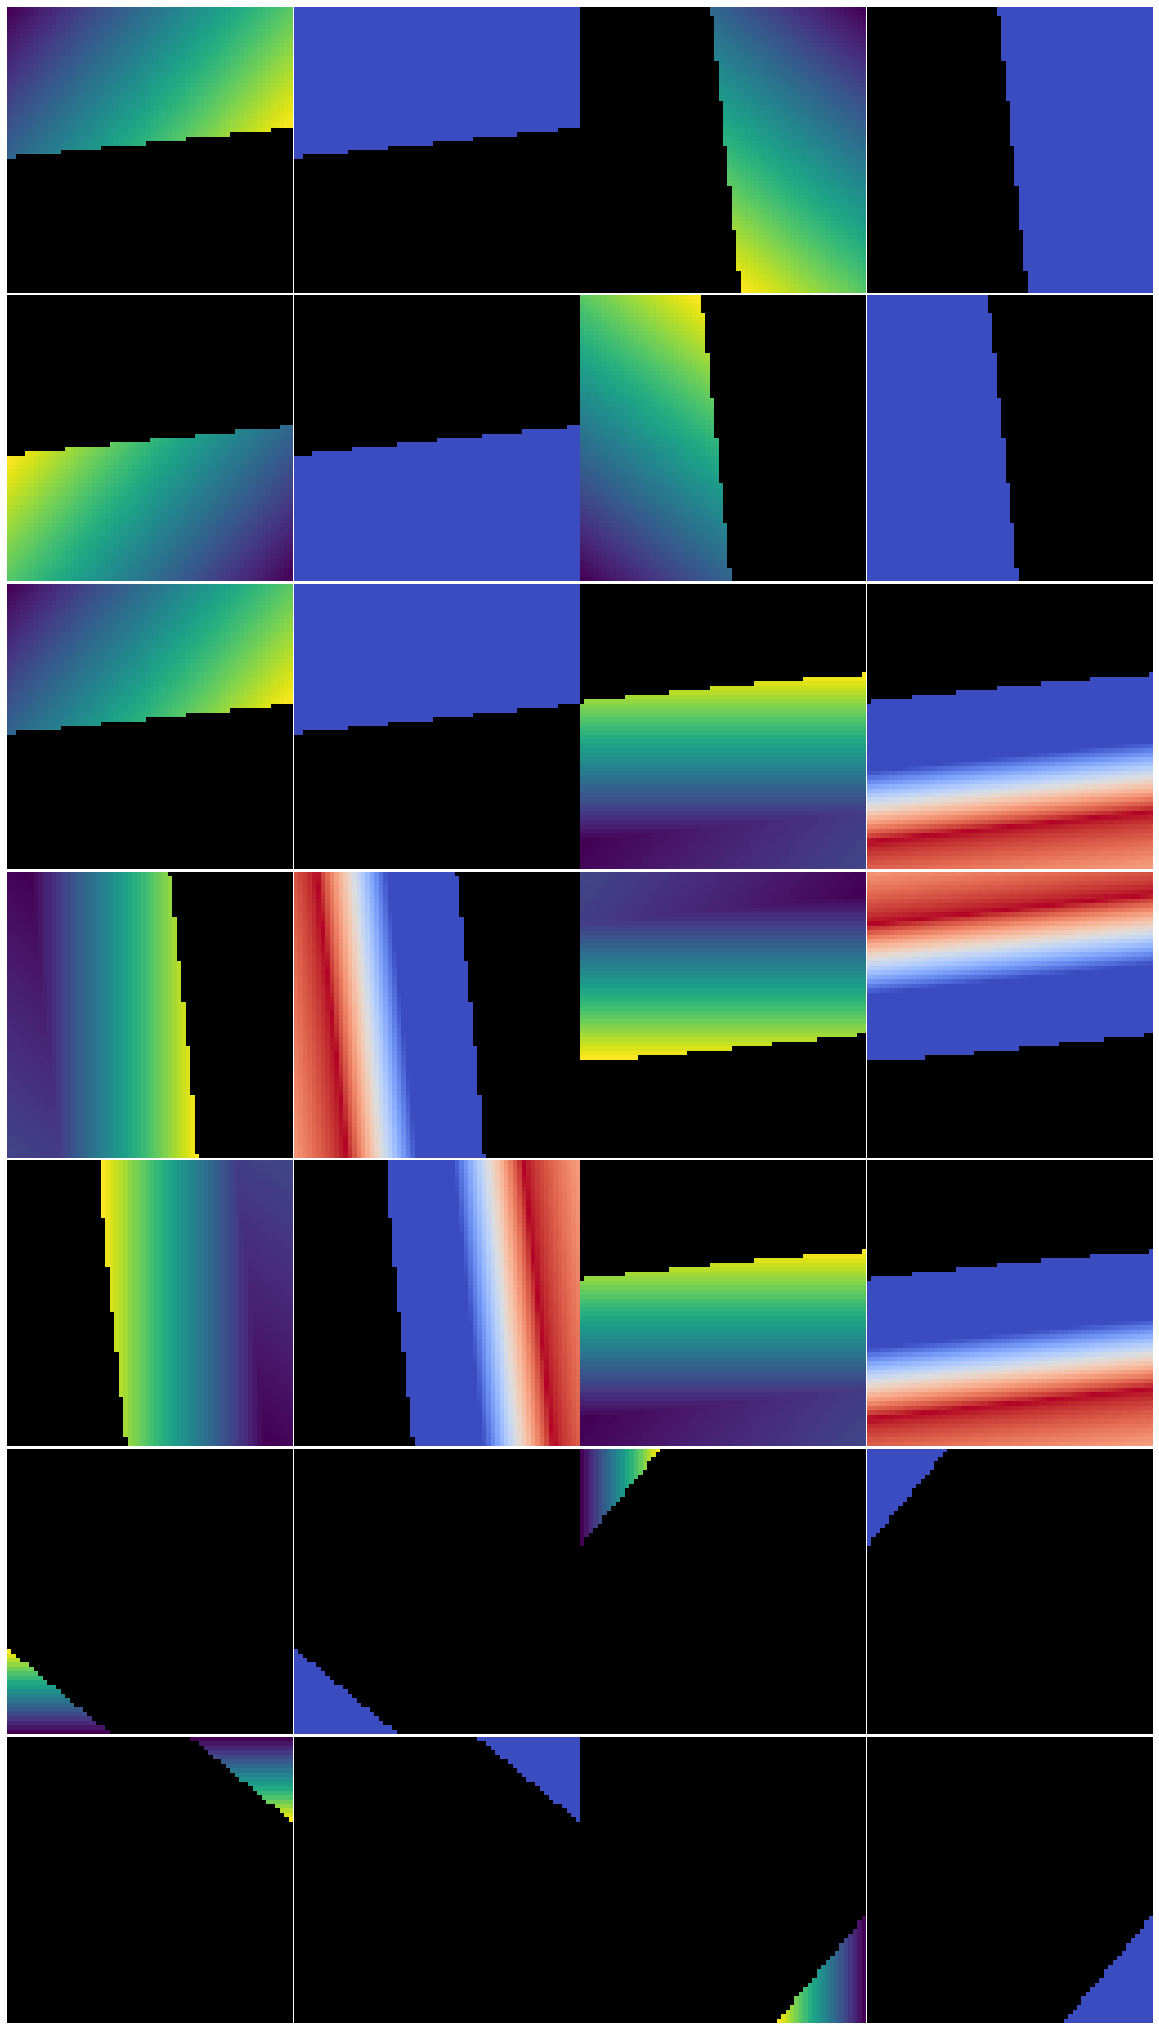

In [222]:
idx = np.random.choice(np.arange(len(images)), replace=False, size=1)

display_depth_sharpness(
    depth_images=images[:20],
    sharpness_images=distances[:20],
    axes_size=(4, 4),
    ncols=2
)

In [223]:
import json
with open('/code/scripts/data_scripts/configs/depthmap_datasets/dataset_config_high_res_clean_64x64.json') as config_file:
    config = json.load(config_file)

config

{'shape_fabrication_extent': 10.0,
 'short_curve_quantile': 0.25,
 'base_n_points_per_short_curve': 8,
 'base_resolution_3d': 0.125,
 'camera_pose': {'type': 'composite',
  'sequences': [{'type': 'sphere_to_origin', 'n_images': 10},
   {'type': 'xy_translation', 'n_images': 100},
   {'type': 'z_rotation', 'n_images': 5}]},
 'imaging': {'type': 'raycasting',
  'projection': 'ortho',
  'resolution_image': 64,
  'resolution_3d': 0.02,
  'fov': [115, 85, 80],
  'validate_image': True},
 'noise': {'type': 'many_noisers', 'subtype': 'z_direction', 'scale': [0.0]},
 'annotation': {'type': 'surface_based_aabb', 'distance_upper_bound': 1.0},
 'smell_coarse_surfaces_by_num_edges': {'num_edges_threshold': 8},
 'smell_coarse_surfaces_by_angles': {'max_angle_threshold_degrees': 10.0},
 'smell_deviating_resolution': {'resolution_3d': 0.02,
  'resolution_deviation_tolerance': 0.01},
 'smell_sharpness_discontinuities': {},
 'smell_bad_face_sampling': {'min_points_per_face': 0.02,
  'max_points_per_fac

In [224]:
imaging = load_func_from_config(IMAGING_BY_TYPE, config['imaging'])

In [255]:
idx = 10
image = images[idx]
distance = distances[idx]
camera_pose = camera_poses[idx]

In [256]:
points = camera_pose.camera_to_world(imaging.image_to_points(image))

In [257]:
display_sharpness(
    None, plot_meshvert=True, meshvert_psize=imaging.resolution_3d / 2,
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
    samples=points[~np.isnan(points)].reshape(-1, 3), samples_psize=0.02,
    samples_distances=distance[image != 0].ravel()
)

Output()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[4.5, 4.5, 4.5, 0.0…

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [43]:
idx = 349
item = dataset[idx]

display_sharpness(
#     sharp_vert=camera_pose.camera_to_world(imaging.rays_origins), sharpvert_psize=0.5,
    samples=item['points'].numpy(), samples_psize=0.02,
    samples_distances=item['distances'].numpy()
)
print({key: value for key, value in item.items() if key.startswith('has_smell')})
print(4096 / len(item['orig_face_indexes']))

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

{'has_smell_deviating_resolution': False, 'has_smell_mismatching_surface_annotation': True, 'has_smell_coarse_surfaces_by_angles': False, 'has_smell_sharpness_discontinuities': False, 'has_smell_bad_face_sampling': False, 'has_smell_coarse_surfaces_by_num_faces': False}
5.843081312410842


In [18]:
item

{'orig_face_indexes': array([11675, 11677, 11687, 11692, 11698, 11699, 11704, 11718, 11724,
        11736, 11749, 11750, 11751, 11766, 11795, 11799, 11974, 12011,
        12012, 12023, 12030, 12039, 12041, 12043, 12071, 12076, 12077,
        12078, 12081, 12090, 12095, 12096, 12149, 12151, 12153, 12155,
        12156, 12158, 12171, 12173, 12175, 12177, 12178, 12182, 12187,
        12189, 12191, 12194, 12196, 12227, 12228, 12229, 12230, 12232,
        12234, 12235, 12236, 12240, 12241, 12242, 12247, 12261, 12262,
        12265, 12288, 12289, 12290, 12306, 12310, 12329, 12335, 12346,
        12359, 12360, 12361, 12374, 12375, 12377, 12379, 12395, 12401,
        12402, 12403, 12412, 12416, 12417, 12418, 12423, 12424, 12430,
        12431, 12432, 12433, 12435, 12445, 12446, 12447, 12449, 12450,
        12452, 12463, 12465, 12466, 12468, 12512, 12542, 12646, 12704,
        12726, 12960, 13249, 13268, 13269, 13270, 13276, 13277, 13278,
        13280, 13281, 13282, 13283, 13294, 13367, 13368,

In [98]:
from sharpf.utils.abc_utils.abc.abc_data import ABCModality, ABCChunk, ABC_7Z_FILEMASK
from sharpf.utils.abc_utils.mesh.io import trimesh_load
import yaml
from sharpf.utils.abc_utils.abc.feature_utils import compute_features_nbhood, remove_boundary_features, get_curves_extents, get_boundary_vertex_indexes
from sharpf.utils.abc_utils.mesh.indexing import reindex_zerobased, compute_relative_indexes
from copy import deepcopy

In [59]:
data_holder =  ABCChunk(['/data/abc/abc_0056_obj_v00.7z', '/data/abc/abc_0056_feat_v00.7z'])

In [62]:
abc_item = data_holder.get(item['item_id'].decode("utf-8")) 

In [64]:
# mesh, vertex_normals, vertex_normal_indices = trimesh_load(item.obj)
mesh, _, _ = trimesh_load(abc_item.obj)

features = yaml.load(abc_item.feat, Loader=yaml.Loader)

In [99]:
def remove_boundary_features(mesh, features, how='none'):
    """Removes features indexed into vertex edges adjacent to 1 face only.
    :param how: 'all_verts': remove entire feature curve if all vertices are boundary
                'edges': remove vertices that belong to boundary edges only (not to other edges)
                'verts': remove vertices that are boundary
                'none': do nothing
    """
    if how == 'none':
        return features

    boundary_vertex_indexes, boundary_edges = get_boundary_vertex_indexes(mesh)

    non_boundary_curves = []
    for curve in features['curves']:
        non_boundary_curve = deepcopy(curve)

        if how == 'all_verts':
            if np.all([vert_index in boundary_vertex_indexes
                       for vert_index in curve['vert_indices']]):
                continue

        elif how == 'verts':
            non_boundary_vert_indices = np.array([
                vert_index for vert_index in curve['vert_indices']
                if vert_index not in boundary_vertex_indexes
            ])
            if len(non_boundary_vert_indices) == 0:
                continue
            non_boundary_curve['vert_indices'] = non_boundary_vert_indices

        elif how == 'edges':
            curve_edges = mesh.edges_unique[
                np.where(
                    np.all(np.isin(mesh.edges_unique, curve['vert_indices']), axis=1)
                )[0]
            ]
            non_boundary = (curve_edges[:, None] != boundary_edges).any(2).all(1)
            non_boundary_vert_indices = np.unique(curve_edges[non_boundary])
            if len(non_boundary_vert_indices) == 0:
                continue
            non_boundary_curve['vert_indices'] = non_boundary_vert_indices

        non_boundary_curves.append(non_boundary_curve)

    non_boundary_features = {
        'curves': non_boundary_curves,
        'surfaces': features.get('surfaces', [])
    }
    return non_boundary_features


In [100]:
mesh_face_indexes = item['orig_face_indexes']
mesh_vertex_indexes = item['orig_vert_indices']

nbhood = reindex_zerobased(mesh, mesh_vertex_indexes, mesh_face_indexes)

nbhood_features = compute_features_nbhood(mesh, features, mesh_face_indexes, mesh_vertex_indexes)

nbhood_features2 = remove_boundary_features(nbhood, nbhood_features, how='edges')


In [101]:
len(nbhood_features['curves']), len(nbhood_features2['curves'])

(4, 1)

In [107]:
import tqdm

In [110]:
def get_num_sharp_curves(dataset):
    
    num_sharp_curves_by_item = []
    
    with ABCChunk(['/data/abc/abc_0056_obj_v00.7z', '/data/abc/abc_0056_feat_v00.7z']) as data_holder:
        
        for abc_item in tqdm.tqdm(data_holder):
            mesh, _, _ = trimesh_load(abc_item.obj)
            features = yaml.load(abc_item.feat, Loader=yaml.Loader)

            
        
#         for item in tqdm.tqdm(dataset):

#             abc_item = data_holder.get(item['item_id'].decode("utf-8")) 
#             # mesh, vertex_normals, vertex_normal_indices = trimesh_load(item.obj)
#             mesh, _, _ = trimesh_load(abc_item.obj)
#             features = yaml.load(abc_item.feat, Loader=yaml.Loader)


#         mesh_face_indexes = item['orig_face_indexes']
#         mesh_vertex_indexes = item['orig_vert_indices']


#         nbhood = reindex_zerobased(mesh, mesh_vertex_indexes, mesh_face_indexes)

#         nbhood_features = compute_features_nbhood(mesh, features, mesh_face_indexes, mesh_vertex_indexes)

#         nbhood_features = remove_boundary_features(nbhood, nbhood_features, how='edges')

#         num_sharp_curves = len([
#             curve for curve in nbhood_features['curves']
#             if curve['sharp']])
        
        num_sharp_curves_by_item.append(0)
        num_sharp_curves_by_item.append(num_sharp_curves)
        
    return num_sharp_curves_by_item

In [111]:
get_num_sharp_curves(dataset)

  2%|▏         | 175/7846 [1:11:26<52:11:35, 24.49s/it] 


KeyboardInterrupt: 

In [94]:
display_sharpness(
    mesh,
    sharp_vert=nbhood.vertices[nbhood_features2['curves'][3]['vert_indices']], sharpvert_psize=0.5,
    samples=mesh.vertices[mesh_vertex_indexes], samples_psize=0.25,
#     samples_distances=item['distances'].numpy()
)



Output()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[4.5, 4.5, 4.5, 0.0…

In [ ]:
nbhood_features = compute_features_nbhood(mesh, features, mesh_face_indexes, mesh_vertex_indexes)

In [71]:
bad_patches = 0
for i, item in tqdm.tqdm(enumerate(dataset)):
    for key, value in item.items():
        if key.startswith('has_smell'):
            if not value:
                bad_patches += 1
                break
        
#     if item['has_smell_coarse_surfaces_by_angles']:
#         print(i)

3021it [00:03, 816.56it/s]


In [75]:
has_smell_coarse_surfaces_by_num_faces = np.array([
    item['has_smell_coarse_surfaces_by_num_faces']
    for i, item in tqdm.tqdm(enumerate(dataset))])

3021it [00:03, 825.23it/s]


In [78]:
has_smell_mismatching_surface_annotation = np.array([
    item['has_smell_mismatching_surface_annotation']
    for i, item in tqdm.tqdm(enumerate(dataset))])

3021it [00:04, 736.48it/s]


In [80]:
has_smell_sharpness_discontinuities = np.array([
    item['has_smell_sharpness_discontinuities']
    for i, item in tqdm.tqdm(enumerate(dataset))])

3021it [00:03, 778.94it/s]


In [82]:
has_smell_coarse_surfaces_by_angles = np.array([
    item['has_smell_coarse_surfaces_by_angles']
    for i, item in tqdm.tqdm(enumerate(dataset))])

3021it [00:03, 820.75it/s]


In [84]:
has_smell_bad_face_sampling = np.array([
    item['has_smell_bad_face_sampling']
    for i, item in tqdm.tqdm(enumerate(dataset))])

3021it [00:03, 785.28it/s]


In [87]:
has_smell_deviating_resolution = np.array([
    item['has_smell_deviating_resolution']
    for i, item in tqdm.tqdm(enumerate(dataset))])

3021it [00:03, 829.98it/s]


In [104]:
np.sum(has_smell_sharpness_discontinuities | 
       has_smell_coarse_surfaces_by_angles | 
       has_smell_deviating_resolution | 
       has_smell_coarse_surfaces_by_num_faces)


711

In [49]:
batch_size = 16
train_loader = DataLoader(
    dataset,
    num_workers=4,
    batch_size=batch_size,
    shuffle=False,
)

In [16]:
len(dataset)

1

In [376]:
num_surfaces = 8

idx_num_surfaces = np.array([i
    for i in range(len(dataset))
    if dataset[i]['num_surfaces'] == num_surfaces
])



In [377]:
len(idx_num_surfaces)

519

In [388]:
sphere = np.random.randn(3, 1000)
sphere /= np.linalg.norm(sphere, axis=0)

i = np.random.choice(idx_num_surfaces)

points = dataset[i]['points']
distances = dataset[i]['distances']

# n_points = len(points)
# theta = 3.0
# p = torch.exp(-distances * theta)
# p /= torch.sum(p)
# i_subset = np.random.choice(
#     np.arange(n_points), size=1024, replace=False, p=p.numpy())
# points, distances = points[i_subset], distances[i_subset]

display_sharpness(samples=points.numpy(), 
                  samples_distances=distances.numpy(),
                  samples_psize=0.06,
                  sharp_vert=None,
                  sharpvert_psize=0.01)

Output()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[4.5, 4.5, 4.5, 0.0…

# Overfitting the model 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

from itertools import islice

In [ ]:

def knn(x, k):
#     print(x.shape)
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx, pairwise_distance


def get_graph_feature(x, k=20, idx=None):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
#     print(x.shape)
    if idx is None:
        idx, dist = knn(x, k=k)   # (batch_size, num_points, k)
    device = torch.device('cuda:2')

    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base

    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 

    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2)
  
    return feature


class DGCNN_SEMSEG(torch.nn.Module):
    def __init__(self, k=30, dropout=0.1, output_channels=40):
        super(DGCNN_SEMSEG, self).__init__()
        self.k = k
        self.dropout = dropout
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)
        self.bn6 = nn.BatchNorm2d(64)
        self.bn7 = nn.BatchNorm2d(1024)
        self.bn8 = nn.BatchNorm2d(512)
        self.bn9 = nn.BatchNorm2d(256)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.ReLU())
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.ReLU())
        self.conv5 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1, bias=False),
                                   self.bn6,
                                   nn.ReLU())
        self.conv7 = nn.Sequential(nn.Conv2d(64*3, 1024, kernel_size=1, bias=False),
                                   self.bn7,
                                   nn.ReLU())
        self.conv8 = nn.Sequential(nn.Conv2d(1024+64*3, 512, kernel_size=1, bias=False),
                                   self.bn8,
                                   nn.ReLU())
        self.conv9 = nn.Sequential(nn.Conv2d(512, 256, kernel_size=1, bias=False),
                                   self.bn9,
                                   nn.ReLU())
        self.conv10 = nn.Conv2d(256, 1, kernel_size=1, bias=False)
        
        self.max_pooling = nn.MaxPool2d([1024,1])

        self.dp1 = nn.Dropout(p=self.dropout)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.transpose(2, 1)
#         print(x.shape)
        
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x = self.conv2(x)
        x1 = x.max(dim=-1, keepdim=True)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv3(x)
        x = self.conv4(x)
        x2 = x.max(dim=-1, keepdim=True)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv5(x)
        x = self.conv6(x)
        x3 = x.max(dim=-1, keepdim=True)[0]

#        x = get_graph_feature(x3, k=self.k)
#        x = self.conv4(x)
#        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3), dim=1)
        x = self.conv7(x)
        x = self.max_pooling(x)
        
        expand = torch.repeat_interleave(x, 1024, 2)
        
        x = torch.cat((expand, x1, x2, x3), dim=1)
        x = self.conv8(x)
        x = self.conv9(x)
        
        x = self.dp1(x)
        
        x = self.conv10(x)
        x = torch.squeeze(x)

        return x


In [ ]:
device = 'cuda:2'

lr = 1e-3
epochs = 1

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = DGCNN_SEMSEG(k=30).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = torch.nn.SmoothL1Loss(reduction='mean')

In [ ]:
epochs_completed = 0
batches_completed_in_epoch = 0

In [311]:
batch_size = 16
train_loader = DataLoader(
    dataset,
    num_workers=4,
    batch_size=batch_size,
    shuffle=False,
)

In [312]:
for batch in tqdm.tqdm(train_loader):
    pass

100%|██████████| 194/194 [00:00<00:00, 438.80it/s]


In [ ]:
end_batch_train = len(train_loader)

In [ ]:
def prepare_batch_on_device(batch_data, device, batch_size):
    points = batch_data['points'].type(torch.float32).to(device, non_blocking=True)
    distances = batch_data['distances'].type(torch.float32).to(device, non_blocking=True)

    # center: E p_i = 0
    points -= points.mean(axis=1, keepdim=True)

    # scale: sup_i ||p_i|| = 1
    points_scales = points.norm(dim=2).max(dim=1).values
    points /= points_scales.reshape((batch_size, 1, 1))
    distances /= points_scales.reshape((batch_size, 1))
    
    # random rotation
    rotation_matrix = random_3d_rotation_matrix().to(device, non_blocking=True)
    points = torch.matmul(points, rotation_matrix[:3, :3])

    return points, distances

In [ ]:
for epoch_i in range(epochs_completed, epochs_completed + epochs):
    print('Training epoch {}'.format(epoch_i))
    
    for batch_i, batch_data in islice(enumerate(train_loader), batches_completed_in_epoch, end_batch_train):
        print('Training batch {}'.format(batch_i))
        iter_i = (epoch_i * len(train_loader) + batch_i) * train_loader.batch_size

        model.train()
        data, label = prepare_batch_on_device(batch_data, device, batch_size)
        
        break

        preds = model.forward(data)
    
        loss = criterion(preds, label)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
    
        # Output loss for each training step, as it is already computed
        print('Training iteration [{item_idx} / {num_batches}] {percent:.3f}% complete, loss: {loss:.4f}'.format(
                item_idx=batch_i, num_batches=end_batch_train,
                percent=100. * batch_i / end_batch_train, loss=loss.item()))


In [ ]:
loss_values = []

In [ ]:
for i in range(10000):
    data, label = prepare_batch_on_device(batch_data, device, batch_size)
    
    preds = model.forward(data)

    loss = criterion(preds, label)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    # Output loss for each training step, as it is already computed
    mse = (preds.detach().cpu().numpy() - label.detach().cpu().numpy()) ** 2
    print('Training iteration [{item_idx} / {num_batches}] {percent:.3f}% complete, '
          'loss: {loss:.4f}, rmse: {rmse:.4f}'.format(
            item_idx=i, num_batches=10000,
            percent=100. * i / 10000, 
            loss=loss.item(), rmse=np.sqrt(mse)))

    loss_values.append(loss.item())
    
    if i % 1000 == 0:
        for g in optimizer.param_groups:
            g['lr'] /= 2
        


In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
plt.plot(loss_values)
plt.yscale('log')
# plt.xscale('log')

In [ ]:
data.detach().cpu().numpy()[0]

In [ ]:
display_sharpness(samples=data.detach().cpu().numpy()[0], 
                  samples_distances=preds.detach().cpu().numpy(),
                  samples_psize=0.04, distance_range=[0, 0.5])

In [ ]:
display_sharpness(samples=data.detach().cpu().numpy()[0], 
                  samples_distances=label.detach().cpu().numpy(),
                  samples_psize=0.04, distance_range=[0, 0.5])

In [ ]:
abs_error = np.abs((preds-label[0]).detach().cpu().numpy())

In [ ]:
abs_error

In [ ]:
_ = plt.hist(
    abs_error
    , bins=100)
plt.yscale('log')

In [ ]:
i = np.where(abs_error < 1e-3)[0]

display_sharpness(samples=data.detach().cpu().numpy()[0][i], 
                  samples_distances=abs_error[i],
                  samples_psize=0.04, 
                  sharp_vert=data.detach().cpu().numpy()[0], sharpvert_color=0x666666, sharpvert_psize=0.01,
                  cmap_distances=k3d.colormaps.basic_color_maps.CoolWarm, 
                  distance_range=(0, .1))

In [ ]:
display_sharpness(samples=data.detach().cpu().numpy()[0], 
                  samples_distances=abs_error,
                  samples_psize=0.04, 
                  cmap_distances=k3d.colormaps.basic_color_maps.CoolWarm, 
                  distance_range=(-.1, .1))

In [7]:
transform = CompositeSharpnessTransform([
    TypeCast(torch.float32, torch.float32),
    Center(),
    NormalizeL2(),
    Random3DRotation(),
#     RandomSubsamplePoints(1024, 3.0),
])

NameError: name 'CompositeSharpnessTransform' is not defined